Importação Bibliotecas

In [17]:
!pip install kagglehub
import os
import shutil
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

Baixando os dados do Kaggle

In [18]:
path = kagglehub.dataset_download("msambare/fer2013")
dataset_path = path  # Original (read-only)
print("Dataset baixado em:", dataset_path)

Dataset baixado em: /kaggle/input/fer2013


Baixando os arquivos

In [19]:
working_dir = "/content/fer2013"
if not os.path.exists(working_dir):
    shutil.copytree(dataset_path, working_dir)
    print("✔️ Copiado para:", working_dir)
else:
    print("⚠️ Diretório já existe:", working_dir)

⚠️ Diretório já existe: /content/fer2013


Excluindo os arquivos que não são "happy" e "sad"

In [20]:
def keep_only_classes(base_path, allowed_classes):
    for split in ['train', 'test']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue
        for class_dir in os.listdir(split_path):
            class_path = os.path.join(split_path, class_dir)
            if os.path.isdir(class_path) and class_dir not in allowed_classes:
                shutil.rmtree(class_path)
                print(f"❌ Removido: {class_path}")
            else:
                print(f"✅ Mantido: {class_path}")

keep_only_classes(working_dir, allowed_classes=['happy', 'sad'])


✅ Mantido: /content/fer2013/train/happy
✅ Mantido: /content/fer2013/train/sad
✅ Mantido: /content/fer2013/test/happy
✅ Mantido: /content/fer2013/test/sad


Verificando se foram excluidos

In [21]:
print("Treino:", os.listdir(os.path.join(working_dir, 'train')))
print("Teste:", os.listdir(os.path.join(working_dir, 'test')))

Treino: ['happy', 'sad']
Teste: ['happy', 'sad']


Pré-processamento com ImageDataGenerator

In [23]:
batch_size = 32
img_size = (224, 224)

train_dir = os.path.join(working_dir, 'train')
test_dir = os.path.join(working_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 12045 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.


Modelo com Transfer Learning (MobileNetV2)

In [24]:
base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binário: happy vs sad
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Treinamento

In [25]:
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 152s 374ms/step - accuracy: 0.6655 - loss: 0.6251 - val_accuracy: 0.7590 - val_loss: 0.5104
Epoch 2/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 133s 352ms/step - accuracy: 0.7348 - loss: 0.5245 - val_accuracy: 0.7531 - val_loss: 0.5016
Epoch 3/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 143s 354ms/step - accuracy: 0.7516 - loss: 0.4995 - val_accuracy: 0.7802 - val_loss: 0.4702
Epoch 4/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 133s 353ms/step - accuracy: 0.7587 - loss: 0.4913 - val_accuracy: 0.7769 - val_loss: 0.4701
Epoch 5/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 133s 353ms/step - accuracy: 0.7538 - loss: 0.4929 - val_accuracy: 0.7799 - val_loss: 0.4666
Epoch 6/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 134s 354ms/step - accuracy: 0.7709 - loss: 0.4803 - val_accuracy: 0.7908 - val_loss: 0.4477
Epoch 7/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 132s 350ms/step - accuracy: 0.7659 - loss: 0.4789 - val_accuracy: 0.7762 - val_loss: 0.4649
Epoch 8/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 143s 353ms/step - accuracy: 0.7676 -

Avaliação

95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7948 - loss: 0.4364

✅ Acurácia final no conjunto de teste: 0.79


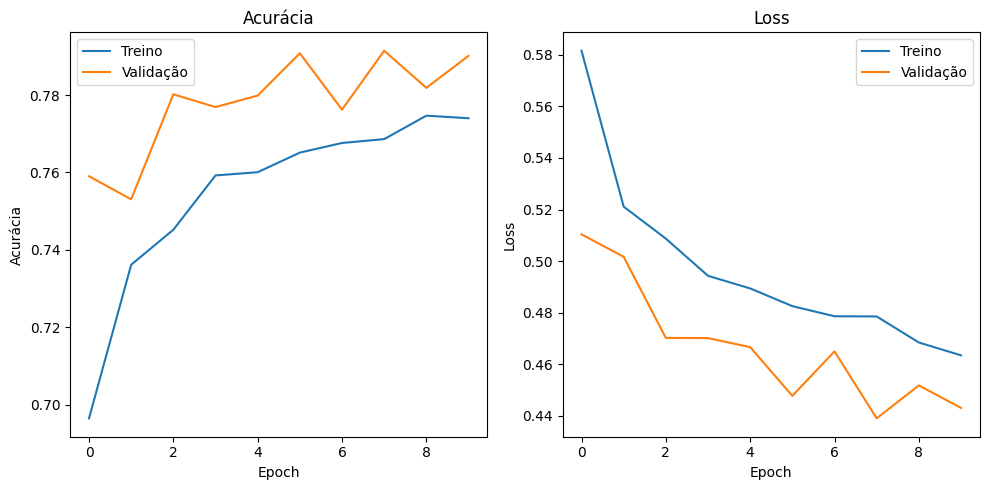

In [26]:
loss, acc = model.evaluate(test_generator)
print(f"\n✅ Acurácia final no conjunto de teste: {acc:.2f}")

# Gráfico de acurácia
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Epoch')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()